<a href="https://colab.research.google.com/github/Arttys1/Projet_IA/blob/main/TP_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#All Installation
!pip install torchsummary
!pip install torchmetrics
!pip install opendatasets
!pip install pandas

In [ ]:
#All Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import opendatasets as od

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

import torch.nn as nn
import torchvision.models as models

from torchsummary import summary

import torch.optim as optim
from torchmetrics import Accuracy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [ ]:
#Download datas form Kaggle into Colab
#url = 'https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data'
url = 'https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign/data'
od.download(url)

#{"username":"shinorhinda","key":"38612192ca8cd1bd4bb69c9baf72a244"}

Skipping, found downloaded files in "./skin-cancer-malignant-vs-benign" (use force=True to force download)


In [ ]:
# train sample and test sample
import os

train_dir = '/content/skin-cancer-malignant-vs-benign/train'
test_dir = '/content/skin-cancer-malignant-vs-benign/test'

#train_dir = '/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
#test_dir = '/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

dirs = os.listdir(train_dir)
classes = {k: v for k,v in zip(dirs, range(len(dirs)))}
classes

{'benign': 0, 'malignant': 1}

In [ ]:
# Nombre d'image par classe
print("Training")
for class_name in classes:
  class_dir = os.path.join(train_dir, class_name)
  num_files = len(os.listdir(class_dir))
  print(f"Class: {class_name}, Number of files: {num_files}")
print()
print("Testing")
for class_name in classes:
  class_dir = os.path.join(test_dir, class_name)
  num_files = len(os.listdir(class_dir))
  print(f"Class: {class_name}, Number of files: {num_files}")

Training
Class: benign, Number of files: 1440
Class: malignant, Number of files: 1197

Testing
Class: benign, Number of files: 360
Class: malignant, Number of files: 300


In [ ]:
# Function to ingest data using training and test loaders
def load_dataset(train_dir, test_dir):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),

        #transforms.Resize((180,180))
    ])

    # Load all of the images, transforming them
    train_dataset = torchvision.datasets.ImageFolder(
        root=train_dir,
        transform=transformation
    )
    test_dataset = torchvision.datasets.ImageFolder(
        root=train_dir,
        transform=transformation
    )


    # Split into training (70% and testing (30%) datasets)
    train_size = len(train_dataset)
    test_size = len(test_dataset)

    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_dir,test_dir)
print('Data loaders ready')

Data loaders ready


In [ ]:

# import required module
from PIL import Image

# get image
filepath = "/content/skin-cancer-malignant-vs-benign/train/benign/100.jpg"
img = Image.open(filepath)

# get width and height
width = img.width
height = img.height

# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)


The height of the image is:  224
The width of the image is:  224


In [ ]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=9):
        super(Net, self).__init__()

        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)

        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)

        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=56 * 56 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))

        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))

        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))

        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)

        # Flatten
        x = x.view(-1, 56 * 56 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor
        return F.log_softmax(x, dim=1)

print("CNN model class defined!")

CNN model class defined!


In [ ]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)
model = Net().to(device)
summary(model, (3, 224, 224), device=device)

Training on cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 224, 224]             336
         MaxPool2d-2         [-1, 12, 112, 112]               0
            Conv2d-3         [-1, 12, 112, 112]           1,308
         MaxPool2d-4           [-1, 12, 56, 56]               0
            Conv2d-5           [-1, 24, 56, 56]           2,616
         Dropout2d-6           [-1, 24, 56, 56]               0
            Linear-7                    [-1, 9]         677,385
Total params: 681,645
Trainable params: 681,645
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 8.33
Params size (MB): 2.60
Estimated Total Size (MB): 11.50
----------------------------------------------------------------


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    correct = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)
        # acc = accuracy(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Calculate the accuracy for this batch
        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target==predicted).item()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    avg_acu = 100. * correct / len(test_loader.dataset)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss, avg_acu


def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss, 100. * correct / len(test_loader.dataset)


# Now use the train and test functions to train and test the model

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy = Accuracy(task="multiclass", num_classes=2).to(device)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

epochs = 50
for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        training_accuracy.append(train_accuracy)
        validation_loss.append(test_loss)
        validation_accuracy.append(test_accuracy)

Training on cuda
Epoch: 1
Training set [0/2637 (0%)] Loss: 0.660683
Training set [500/2637 (19%)] Loss: 0.000000
Training set [1000/2637 (38%)] Loss: 0.000000
Training set [1500/2637 (57%)] Loss: 38.349625
Training set [2000/2637 (75%)] Loss: 0.000093
Training set [2500/2637 (94%)] Loss: 0.000000
Training set: Average loss: 3.102407
Validation set: Average loss: 12.658840, Accuracy: 1197/2637 (45%)

Epoch: 2
Training set [0/2637 (0%)] Loss: 22.646944
Training set [500/2637 (19%)] Loss: 0.523223
Training set [1000/2637 (38%)] Loss: 0.096616
Training set [1500/2637 (57%)] Loss: 22.661350
Training set [2000/2637 (75%)] Loss: 0.248220
Training set [2500/2637 (94%)] Loss: 0.025014
Training set: Average loss: 4.319344
Validation set: Average loss: 15.392501, Accuracy: 1197/2637 (45%)

Epoch: 3
Training set [0/2637 (0%)] Loss: 26.947556
Training set [500/2637 (19%)] Loss: 0.689952
Training set [1000/2637 (38%)] Loss: 0.665004
Training set [1500/2637 (57%)] Loss: 0.745576
Training set [2000/26

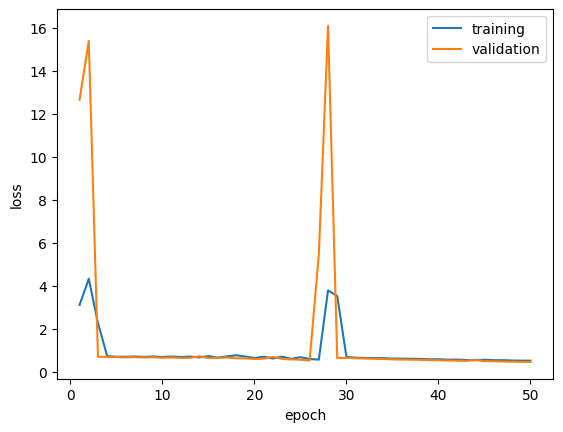

In [ ]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

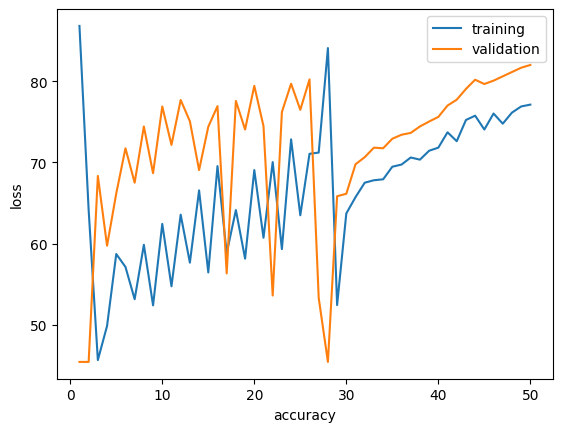

In [ ]:
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

benign


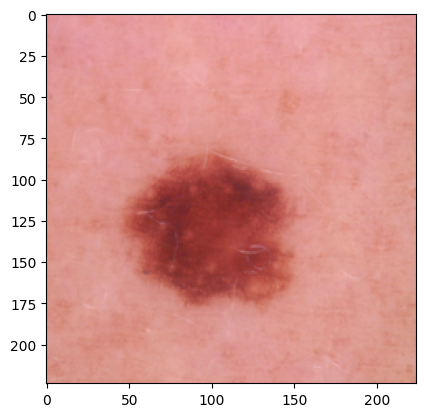

In [ ]:
img = Image.open("/content/skin-cancer-malignant-vs-benign/train/benign/102.jpg")
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
classes = {0:'benign', 1:'malignant'}
plt.imshow(img)
img = transformation(img).to(device)
with torch.no_grad():
      model.eval()
      output =model(img)
      index = output.data.cpu().numpy().argmax()
      class_name = classes[index]
      print(class_name)